Будем пользоваться стандартными средами, реализованными в библиотеке OpenAI Gym (https://gym.openai.com).

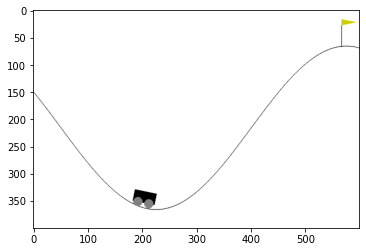

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('c:\\users\\amina\\anaconda3\\lib\\site-packages')
import gym
# создаем окружение
env = gym.make("MountainCar-v0")
env_screen = env.render(mode = 'rgb_array')
plt.imshow(env_screen)
env.close()

### Интерфейс среды в OpenAI gym

Основные методы класса Env:

item reset() - инициализация окружения, возвращает первое наблюдение;
item render() - визуализация текущего состояния среды;
item step($a$) - выполнить в среде действие a и получить: new observation - новое наблюдение после выполнения действия $a$; reward - вознаграждение за выполненное действие $a$; $is\_done$ - True, если процесс завершился, False иначе; $info$ - дополнительная информация;


In [2]:
obs0 = env.reset()
print("изначальное состояние среды:", obs0)
# выполняем действие 2 
new_obs, reward, is_done, _ = env.step(2)
print("новое состояние:", new_obs, 
      "вознаграждение", reward)

изначальное состояние среды: [-0.59669447  0.        ]
новое состояние: [-0.59515065  0.00154383] вознаграждение -1.0


In [3]:
def act(s):
    actions = {'left': 0, 'stop': 1, 'right': 2}
    # в зависимости от полученного состояния среды 
    # выбираем действия так, чтобы тележка достигла флага
    action = actions['left'] if s[1] < 0 else actions["right"]
    return action

# создаем окружение, с ограничением на число шагов в 249
env = gym.wrappers.TimeLimit(
    gym.make("MountainCar-v0").unwrapped,
    max_episode_steps=250)
# проводим инициализацию и запоминаем начальное состояние
s = env.reset()
done = False
while not done:
    # выполняем действие, получаем s, r, done
    s, r, done, _ = env.step(act(s))
    # визуализируем окружение
    env.render()

env.close()
if s[0] > 0.47:
    print("Успех!")
else:
    raise NotImplementedError("""!""")

Успех!


## Q-обучение

Одним из наиболее популярных алгоритм обучения на основе временных различий является Q-обучение. Агент, который принимает решения на основе $Q$-функции, не требует модель для обучения и выбора действий, т.е. такой агент также свободен от модели (model-free), как и TD-агент. Уравнение Беллмана для значения Q-функции в равновесии записывается как:

$$Q(s,a)=r(s)+\gamma\sum_s'T(s,a,s')\max_{a'}Q(a',s')$$

Уравнение для итерационного обновления значений Q-функции выглядит следующим образом:
$$Q(s,a)\leftarrow Q(s,a)+\alpha(r(s)+\gamma\max_{a'}Q(a',s') - Q(s,a)).$$

Оформим этот алгоритм в виде класса QLearningAgent:

In [4]:
import random, math

import numpy as np
from collections import defaultdict


class QLearningAgent():
    """
    Q-Learning агент

    Замечание: избегайте прямое использование 
    self._q_values, для этого определены 
    функции: get_q_value, set_q_value
    """

    def __init__(self, alpha, epsilon, discount, 
                 get_legal_actions):
        self.get_legal_actions = get_legal_actions
        self._q_values = \
            defaultdict(lambda: defaultdict(lambda: 0))  
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_q_value(self, state, action):
        return self._q_values[state][action]

    def set_q_value(self, state, action, value):
        self._q_values[state][action] = value

Добавим нашему агенту возможность вычислять оценки $V$:

In [5]:
def get_value(self, state):
    """
      Возвращает значение функции полезности, 
      рассчитанной по Q[state, action], 
    """
    possible_actions = self.get_legal_actions(state)
    value = max([self.get_q_value(state, action) for action in possible_actions])
    return value

QLearningAgent.get_value = get_value

Стратегия нашего агента будет заключаться в выборе лучшего действия, в соответствии с оценками $Q$:

In [6]:
def get_policy(self, state):
    """
      Выбирает лучшее действие, согласно стратегии.
    """
    possible_actions = self.get_legal_actions(state)
    
    # выбираем лучшее действие, согласно стратегии
    best_action = None
    for action in possible_actions:
        if best_action is None:
            best_action = action
        elif self.get_q_value(state, action) > self.get_q_value(state, best_action):
            best_action = action
       
    return best_action

QLearningAgent.get_policy = get_policy

Для конкретной ситуации мы будем выбирать действие, используя $\epsilon$-жадный подход:

In [7]:
def get_action(self, state):
    """
      Выбирает действие, предпринимаемое в данном 
      состоянии, включая исследование (eps greedy)
      С вероятностью self.epsilon берем случайное 
      действие, иначе действие согласно стратегии 
      (self.get_policy)
    """
    possible_actions = self.get_legal_actions(state)

    # выбираем действие, используя eps-greedy подход
    if np.random.random() < self.epsilon:
        action = np.random.choice(possible_actions, 1)[0]
    else:
        action = self.get_policy(state)
        
    return action

QLearningAgent.get_action = get_action

In [8]:
def update(self, state, action, next_state, reward):
    """
      функция Q-обновления 
    """
    # выполняем Q-обновление, 
    # используем методы getQValue и setQValue
    t = self.alpha*(reward + self.discount*self.get_value(next_state) - self.get_q_value(state, action))
    reference_qvalue = self.get_q_value(state, action) + t
    self.set_q_value(state, action, reference_qvalue)
    
QLearningAgent.update = update

Тестируем нашего агента на задаче Taxi

In [9]:
import gym
env = gym.make("Taxi-v3")

n_actions = env.action_space.n

In [10]:
def play_and_train(env, agent, t_max=10**4):
    """функция запускает полную игру,
    используя стратегию агента (agent.get_action(s))
    выполняет обновление агента (agent.update(...))
    и возвращает общее вознаграждение
    """
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        # выбираем действие
        a = agent.get_action(s)
        next_s, r, done, _ = env.step(a)
        
        # выполняем обновление стратегии
        agent.update(s, a, next_s, r)
        
        s = next_s
        total_reward +=r
        if done:
            break
        
    return total_reward
    

eps = 0.1 mean reward = 5.6
alpha= 0.5


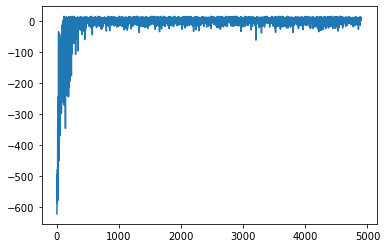

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

agent = QLearningAgent(alpha=0.5, epsilon=0.1,
                       discount=0.9,
                       get_legal_actions=lambda s: range(
                           n_actions))

assert 'get_policy' in dir(agent)
rewards = []
for i in range(5000):
    rewards.append(play_and_train(env, agent))

    if i % 100 == 0:
        clear_output(True)
        print('eps =', agent.epsilon,
              'mean reward =', np.mean(rewards[-10:]))
        print("alpha=", agent.alpha)
        plt.plot(rewards)
        plt.show()

In [12]:
total_reward = 0.0
s = env.reset()
    
for t in range(1000):
    # выбираем действие
    a = agent.get_action(s)
    next_s, r, done, _ = env.step(a)
        
    s = next_s
    total_reward +=r
    if done:
         break
    
    env.render()
total_reward

10.0

: 